## Интеллектуальный анализ данных – весна 2023
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html). 

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [66]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования.

In [67]:
X.isnull().any()
# пропущенные значения отсутсвуют в наборе данных

alcohol                         False
malic_acid                      False
ash                             False
alcalinity_of_ash               False
magnesium                       False
total_phenols                   False
flavanoids                      False
nonflavanoid_phenols            False
proanthocyanins                 False
color_intensity                 False
hue                             False
od280/od315_of_diluted_wines    False
proline                         False
dtype: bool

In [68]:
X.dtypes
# категориальных переменных нет

alcohol                         float64
malic_acid                      float64
ash                             float64
alcalinity_of_ash               float64
magnesium                       float64
total_phenols                   float64
flavanoids                      float64
nonflavanoid_phenols            float64
proanthocyanins                 float64
color_intensity                 float64
hue                             float64
od280/od315_of_diluted_wines    float64
proline                         float64
dtype: object

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

In [69]:
from sklearn.model_selection import train_test_split

In [70]:
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [72]:
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [73]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = data['feature_names'])
scaler.fit(X_test)
X_test = pd.DataFrame(scaler.transform(X_test), columns = data['feature_names'])
X_train_am = X_train[['alcohol', 'magnesium']]
X_test_am = X_test[['alcohol', 'magnesium']]

neighbours = [1, 3, 5, 10, 15, 25]
models = []
labels =[]

print(f'{"NN":<5} {"Train":<5} {"Test":<5}')

for n in neighbours:
    neigh = KNeighborsClassifier(n_neighbors=n, metric='euclidean')
    neigh.fit(X_train_am, y_train)
    
    models.append(neigh)
    labels.append(f'n_neighbours = {n}')
    
    print(f'{n:<5} {neigh.score(X_train_am, y_train):<5.2f} {neigh.score(X_test_am, y_test):<5.2f}')

NN    Train Test 
1     0.99  0.65 
3     0.78  0.65 
5     0.77  0.70 
10    0.73  0.54 
15    0.73  0.57 
25    0.72  0.61 


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/). 

In [11]:
!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [74]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов. 
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново. 
6. Построение графика может занять некоторое время – придётся немного подождать!

In [22]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions
import matplotlib.gridspec as gridspec
import itertools

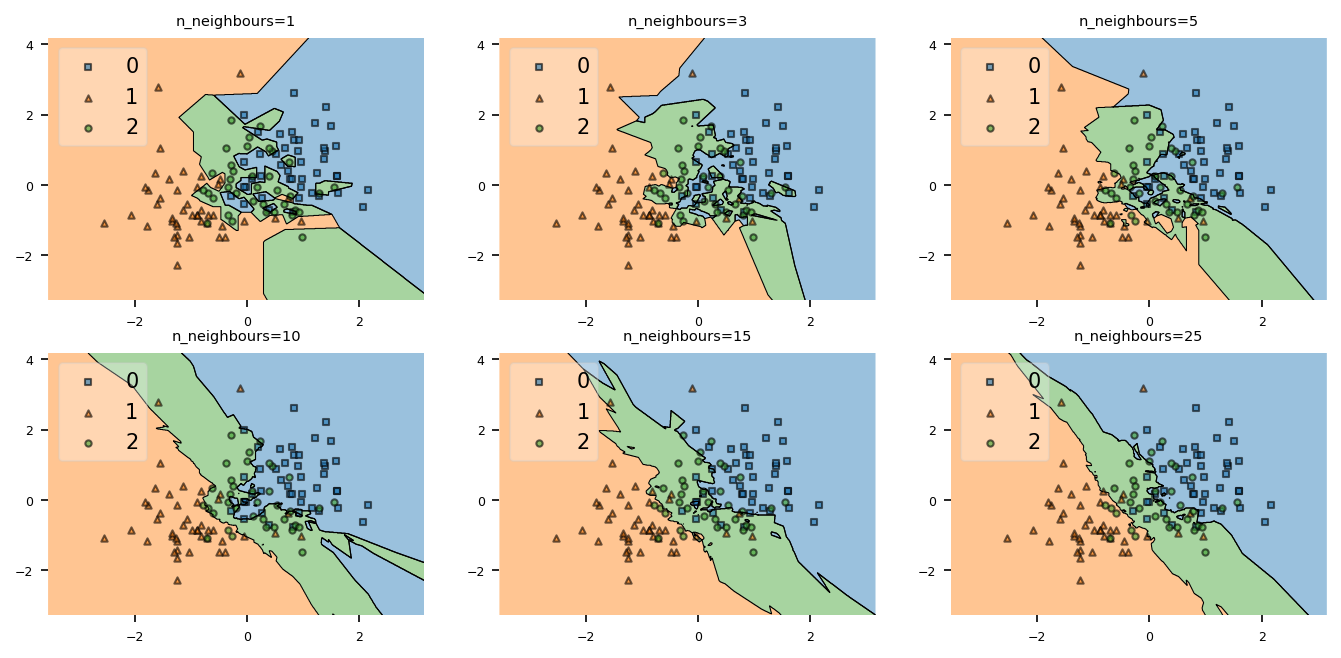

In [86]:
import warnings
warnings.filterwarnings("ignore")

gs = gridspec.GridSpec(2, 3)
fig = plt.figure(figsize=(11,5), dpi=150)

for model, lab, grd in zip(models,
                         labels,
                         list(itertools.product([0, 1, 2], repeat=2))[:6]):

    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=np.array(X_train_am), y=y_train, clf=model, legend=2, scatter_kwargs={'s':9, 'alpha':0.6})
    plt.title(lab, fontsize='7')
    plt.xticks(fontsize='6')
    plt.yticks(fontsize='6')
    

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности.

я бы остановился на 3х соседях
из задания 1.3 видно, что 1 и 3 дают большую долю верных ответов

однако, решающая поверхность при n=3 выглядит лучше, так как там не так много маленьких 'островов'
решающая поверхность при n=1 похожа на решающую поверхность переобученной модели
но наиболее хороший график при n=25

Считаю, что двух признаков маловато для обучения хорошей модели

### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

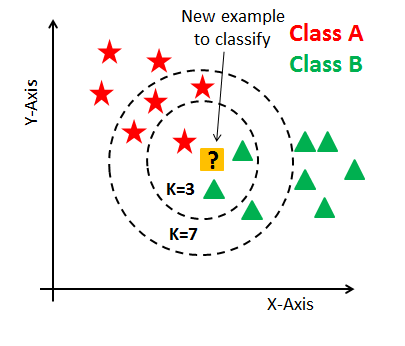

In [83]:
import numpy as np
from collections import Counter 

class KNN:
    def __init__(self, k:int):
        self.k = k
    
    def fit(self, X, y):
        self.objects = X
        self.answers = y
    
    def predict_for_object(self, x):
        distances = zip(np.sum((self.objects - x)**2, axis=1)**0.5, self.answers)
        n_nearest_objects = sorted(distances, key=lambda d: d[0])[:self.k]
        n_nearest_distances, n_nearest_y = zip(*n_nearest_objects)
        
        cnt = Counter(n_nearest_y)
        
        return cnt.most_common(1)[0][0]
    
    def predict(self, X):
        prediction = np.array(list(map(self.predict_for_object, X)))
            
        return prediction

In [84]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [85]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [88]:
data = pd.read_csv('https://raw.githubusercontent.com/ez3nx/datasets/main/diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.1 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их. 

In [89]:
data.isna().any()
# пропусков нет

Unnamed: 0    False
carat         False
cut           False
color         False
clarity       False
depth         False
table         False
price         False
x             False
y             False
z             False
dtype: bool

**Задача 3.2 (0.1 балла)** Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [90]:
data.drop(columns=['Unnamed: 0'], inplace=True)
data.head()

# был бессмылсенный столбец Unnamed: 0

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


**Задача 3.3 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [91]:
data.corr().round(2)

# сильнее всего с ценой коррелирует число карат, и размеры (x, y, z)

,carat,depth,table,price,x,y,z
carat,1.00,0.03,0.18,0.92,0.98,0.95,0.95
depth,0.03,1.00,-0.30,-0.01,-0.03,-0.03,0.09
table,0.18,-0.30,1.00,0.13,0.20,0.18,0.15
price,0.92,-0.01,0.13,1.00,0.88,0.87,0.86
x,0.98,-0.03,0.20,0.88,1.00,0.97,0.97
y,0.95,-0.03,0.18,0.87,0.97,1.00,0.95
z,0.95,0.09,0.15,0.86,0.97,0.95,1.00


**Задача 3.4 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [92]:
data_dum = pd.get_dummies(data, drop_first=True)
data_dum.head()

,carat,depth,table,price,x,y,z,cut_Good,cut_Ideal,cut_Premium,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,1,...,0,1,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,1,0,0,...,0,0,1,0,0,1,0,0,0,0


**Задача 3.5 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3.

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [95]:
np.random.seed(1)

X_train, X_test, y_train, y_test = train_test_split(
    data_dum.drop(columns='price'), data_dum.price, random_state=10, test_size=0.3
)

**Задача 3.6 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [96]:
scaler = StandardScaler()

X_train = pd.DataFrame(data=scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(data=scaler.fit_transform(X_test), columns=X_test.columns)

**Задача 3.7 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [97]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [98]:
lr = LinearRegression()

model = lr.fit(X_train, y_train)

print(f'Train: {mean_squared_error(y_train, lr.predict(X_train))}')
print(f'Test: {mean_squared_error(y_test, lr.predict(X_test))}')

Train: 1268454.955961559
Test: 1314517.4423550963


**Задача 3.8 (0.2 балла)** Изучите документацию модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [99]:
w_lr = pd.DataFrame([lr.coef_], columns=lr.feature_names_in_, index=['simple_lr']).round(2)

w_lr

# видно что оценка признаков carat, x, z на порядок отличаются от других вещественных признаков

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
simple_lr,5268.33,-73.11,-67.59,-959.0,80.66,-238.04,180.16,421.77,345.46,319.33,...,-349.28,-431.94,-513.64,965.64,1586.68,1032.55,1651.3,1808.18,1274.42,1453.38


**Задача 3.9 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом. 

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией. 

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [100]:
from sklearn.linear_model import Lasso, Ridge

In [101]:
lasso = Lasso(10)
ridge = Ridge(10)

lasso_model = lasso.fit(X_train, y_train)
ridge_model = ridge.fit(X_train, y_train)

weights = pd.DataFrame([lr.coef_, lasso_model.coef_, ridge_model.coef_], 
                       columns=lasso_model.feature_names_in_, 
                       index=['simple_lr', 'lasso', 'ridge']
                      ).round(2)

weights

,carat,depth,table,x,y,z,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
simple_lr,5268.33,-73.11,-67.59,-959.00,80.66,-238.04,180.16,421.77,345.46,319.33,...,-349.28,-431.94,-513.64,965.64,1586.68,1032.55,1651.30,1808.18,1274.42,1453.38
lasso,4789.30,-86.42,-76.38,-488.90,-0.00,-194.28,55.06,216.79,157.07,149.18,...,-275.57,-360.54,-453.06,633.62,816.24,363.21,1001.19,1053.32,815.20,924.70
ridge,5231.92,-70.74,-67.73,-906.61,71.90,-247.35,180.79,423.06,346.35,320.83,...,-348.40,-430.68,-512.30,952.55,1554.92,1005.42,1624.81,1777.23,1256.10,1432.03


видно что у ridge регрессии веса не особо изменились, в у lasso изменились достаточно сильно, 
но всё равно остались высокими
проблема мультиколлинеарности стоит очень остро так как между каратами, x, y, z почти линейная связь
парные оценки коэффициентов корреляции почти равны 1 и регуляризация не сильно помогает

**Задача 3.10 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов. 

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

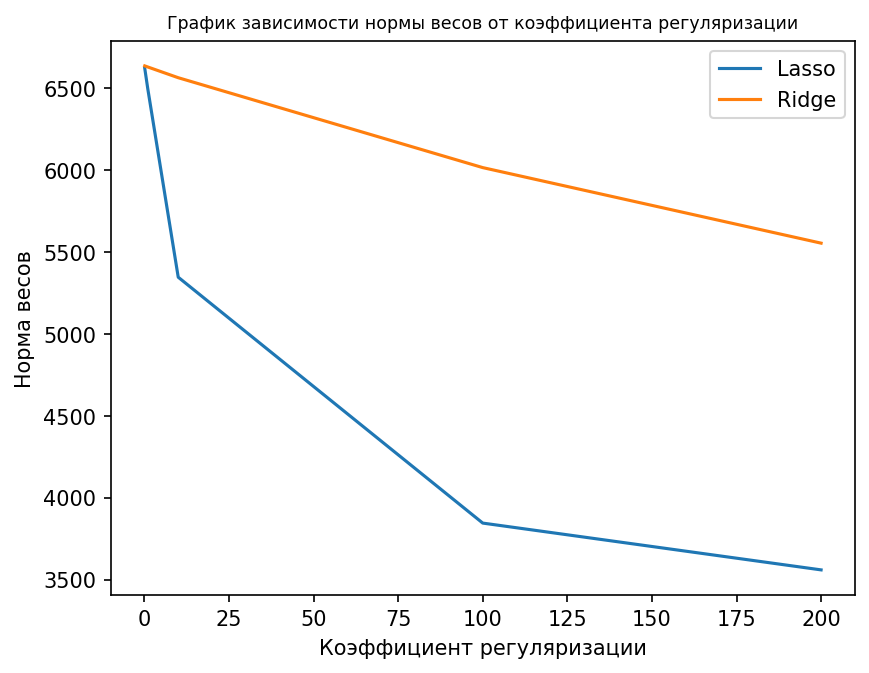

In [102]:
params = [0.1, 1, 10, 100, 200]
lasso_norms = []
ridge_norms = []

for alpha in params:
    lasso = Lasso(alpha).fit(X_train, y_train)
    ridge = Ridge(alpha).fit(X_train, y_train)
    
    lasso_norms.append(np.linalg.norm(lasso.coef_))
    ridge_norms.append(np.linalg.norm(ridge.coef_))
    
fig = plt.figure(dpi=150)
plt.plot(params, lasso_norms, label='Lasso')
plt.plot(params, ridge_norms, label='Ridge')
plt.legend()
plt.title('График зависимости нормы весов от коэффициента регуляризации', size='small')
plt.xlabel('Коэффициент регуляризации')
plt.ylabel('Норма весов')
plt.show()

# видно что Lasso регрессия агрессивнее уменьшает веса, её часто используют для отбора признаков
# так как она зануляет веса при незначимых признаках

**Задача 3.11 (0.5 балла)** 
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке. 

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`. 

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество. 

In [103]:
from sklearn.linear_model import LassoCV

model = LassoCV(alphas=params, cv=5).fit(X_train, y_train)

errors = pd.DataFrame(model.mse_path_, columns=model.alphas_)

errors.mean().round(2)

# наименьшая ошибка при alpha = 0.1, берём его

200.0    1564882.57
100.0    1611681.29
10.0     1556749.30
1.0      1598562.30
0.1      1445731.20
dtype: float64

**Задача 3.12 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [104]:
lasso_model = Lasso(0.1).fit(X_train, y_train)

for weight, feature in zip(lasso_model.coef_, lasso_model.feature_names_in_):
    print(feature, round(weight, 2))

carat 5263.75
depth -73.6
table -67.72
x -947.12
y 69.98
z -235.14
cut_Good 179.06
cut_Ideal 419.93
cut_Premium 343.64
cut_Very Good 317.88
color_E -78.19
color_F -101.77
color_G -190.05
color_H -348.55
color_I -431.23
color_J -513.03
clarity_IF 962.37
clarity_SI1 1579.08
clarity_SI2 1025.94
clarity_VS1 1644.91
clarity_VS2 1800.73
clarity_VVS1 1269.89
clarity_VVS2 1448.17


Наименее важными оказались y, depth и table

Наиболее информативными оказались carat и clarity, интуитивно понятно, что
чистые алмазы, да ещё и с большим числом карат встречаются редко, а значит и цена на них выше

**Задача 3.13 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

In [106]:
print(f'simple_regression: {mean_squared_error(y_test, lr.predict(X_test))}')
print(f'lasso_regression: {mean_squared_error(y_test, lasso_model.predict(X_test))}')


simple_regression: 1314517.4423550963
lasso_regression: 1314152.5914592247


Для предсказаний лучше использовать Lasso регрессию, так как у неё меньше MSE
Lasso лучше, вероятно потому, что мы используем регуляризацию, это нивеллирует воздействие мультиколлинеарности, а также не даёт модели переобучиться